In [1]:
import pyvista as pv
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
import math
import os

In [2]:
CHERNOBYL_COORDS = (30.0927, 51.3870) # (Lon, lat) or (x, y)

MAP_SIZE_IN_DEGREES = (100, 50)

LOWER_LEFT_X_LON = CHERNOBYL_COORDS[0] - MAP_SIZE_IN_DEGREES[0]/2
LOWER_LEFT_Y_LAT = CHERNOBYL_COORDS[1] - MAP_SIZE_IN_DEGREES[1]/2
UPPER_RIGHT_X_LON = CHERNOBYL_COORDS[0] + MAP_SIZE_IN_DEGREES[0]/2
UPPER_RIGHT_Y_LAT = CHERNOBYL_COORDS[1] + MAP_SIZE_IN_DEGREES[1]/2

BOX_WIDTH = 10
IMAGE_X = 1550
IMAGE_Y = 1200
MAP_WIDTH_IN_DEGREES_LON = UPPER_RIGHT_X_LON - LOWER_LEFT_X_LON
MAP_HEIGHT_IN_DEGREES_LAT = UPPER_RIGHT_Y_LAT - LOWER_LEFT_Y_LAT

In [3]:
def box_bounds(centerx, centery, height):
    return (centerx-(BOX_WIDTH/2), centerx+(BOX_WIDTH/2), centery-(BOX_WIDTH/2), centery+(BOX_WIDTH/2), 0 , height)

In [4]:
def lon_lat_to_x_y_merc(lon, lat):
    worldCircumference = (IMAGE_X / MAP_SIZE_IN_DEGREES[0]) * 360
    radius = worldCircumference/ (2 * math.pi)

    # x = ((lon-LOWER_LEFT_X_LON)/MAP_WIDTH_IN_DEGREES_LON) * IMAGE_X
    lonRad = math.radians(lon)
    x = radius * (lonRad)
    
    latRad = math.radians(lat)
    y= radius * math.log(math.tan( (math.pi/4) + (latRad / 2) ))

    x += worldCircumference/2
    y += worldCircumference/2

    return  x, y

In [5]:
def pix_conv(x, y):
    xx, yy = lon_lat_to_x_y_merc(LOWER_LEFT_X_LON,LOWER_LEFT_Y_LAT)
    return x-xx, y-yy

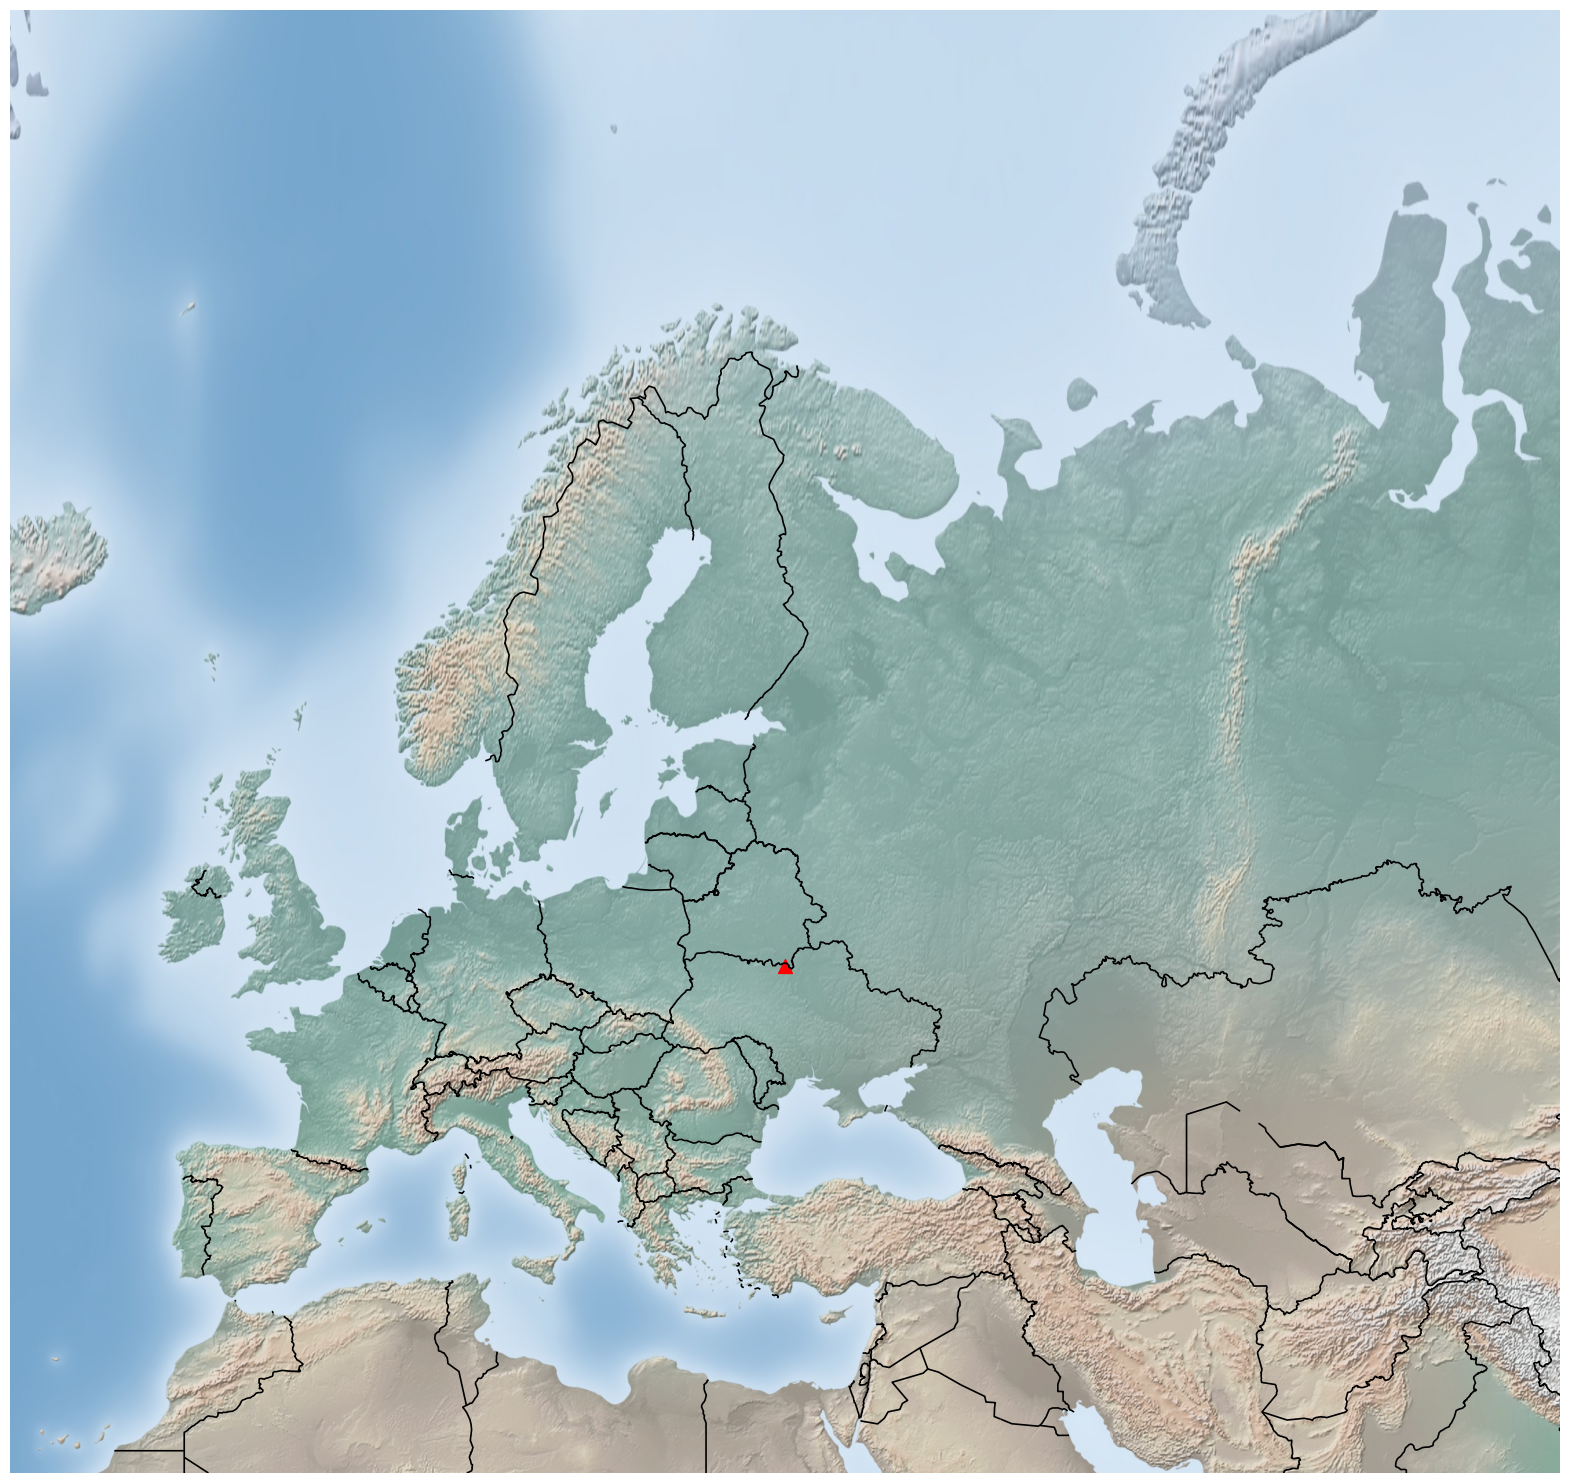

In [6]:
def genMap():
    fig = plt.figure(frameon=False, figsize=(20,20))

    plt.axis("off")

    m = Basemap(projection='merc',
                llcrnrlat=LOWER_LEFT_Y_LAT,
                urcrnrlat=UPPER_RIGHT_Y_LAT,
                llcrnrlon=LOWER_LEFT_X_LON,
                urcrnrlon=UPPER_RIGHT_X_LON,
                lat_ts=20,
                resolution='i')
  
    m.shadedrelief()
    m.drawcountries(linewidth=1.2)
    
    
    # Locate Chernobyl
    m.scatter(CHERNOBYL_COORDS[0], CHERNOBYL_COORDS[1], latlon=True, s=100, c='red', marker='^', alpha=1) # puts a red triangle at the (lon,lat) coordinate
    
    if not "res" in os.listdir():
        os.mkdir("res")
    plt.savefig('res/map_merc_section.jpg',bbox_inches='tight',transparent=True, pad_inches=0, )
genMap()


In [7]:
def render():
    global chernobyl_map
    global plotter
    global date
    global iso

    plotter.clear_actors()

    plotter.add_mesh(chernobyl_map, rgb=True)
    plotter.add_text(f"{date.month}-{date.day}-{date.year}")
    plotter.add_text(f"{iso}", position='lower_left')
    sensor_latitudes = []
    sensor_longitudes = []
    iso_values = []

    if date.day >=10:
        strdate = f"{date.year}-0{date.month}-{date.day}"
    else:
        strdate = f"{date.year}-0{date.month}-0{date.day}"

    for lon, lat, value in data[data.date == strdate].filter(['X','Y', iso]).drop_duplicates().values:
        sensor_longitudes.append(lon)
        sensor_latitudes.append(lat)
        iso_values.append(float(value))

    block = pv.MultiBlock()
    for i in range(len(sensor_latitudes)):
        x, y = lon_lat_to_x_y_merc(sensor_longitudes[i], sensor_latitudes[i])
        x, y = pix_conv(x, y)

        if x<0 or y < 0:
            continue

        bound = box_bounds(x, y, iso_values[i]*5)
        box = pv.Box(bound)
        box["concentration_value"] = [iso_values[i] for _ in range(box.n_cells)]

        block.append(box)


    plotter.add_mesh(block.combine(), color="r", show_edges=True, scalars="concentration_value")

def date_slider(value, slider):
    global iso
    global date
   
    date = datetime.date(1986, 4, 27) + datetime.timedelta(days=int(value))
    slider.GetSliderRepresentation().SetValue(int(value))

    render()
    
def iso_slider(value, slider):
    global iso

    value = round(value, None)
    
    if value == 1:
        iso = "I_131_(Bq/m3)"
    elif value == 2:
        iso = "Cs_134_(Bq/m3)"
    else:
        iso = "Cs_137_(Bq/m3)"

    slider.GetSliderRepresentation().SetValue(value)


    render()

In [8]:
plotter = pv.Plotter(notebook=False)
date_range = [0,35]

data = pd.read_csv("data/cleaned.csv")

date = datetime.date(1986, 4, 27)
iso = "I_131_(Bq/m3)"


plotter.add_slider_widget(date_slider, date_range, value = 0, fmt="%2.0f", pointa=(0.4, .9), pointb=(0.9, .9), title="Day", pass_widget=True)
plotter.add_slider_widget(iso_slider, [1,3], value = 1, fmt="%2.1f", pointa=(0.4, .75), pointb=(0.9, .75), pass_widget=True, title="Isotope")


chernobyl_map: pv.UniformGrid = pv.read("res/map_merc_section.jpg")

IMAGE_X = int(chernobyl_map.bounds[1])
IMAGE_Y = int(chernobyl_map.bounds[3])

render()

plotter.show()

c:\Users\Adam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\utilities\helpers.py:1229: UserWarning: Encountered issue in callback (most recent call last):
  File "C:\Users\Adam\AppData\Local\Temp\ipykernel_5256\2395764669.py", line 50, in date_slider
    render()
  File "C:\Users\Adam\AppData\Local\Temp\ipykernel_5256\2395764669.py", line 9, in render
    plotter.add_mesh(chernobyl_map, rgb=True)
                     ^^^^^^^^^^^^^
NameError: name 'chernobyl_map' is not defined
  warnings.warn(formatted_exception)
c:\Users\Adam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\utilities\helpers.py:1229: UserWarning: Encountered issue in callback (most recent call last):
  File "C:\Users\Adam\AppData\Local\Temp\ipykernel_5256\2395764669.py", line 67, in iso_slider
    render()
  File "C:\Users\Adam\AppData\Local\Temp\ipykernel_5256\2395764669.py", line 9, in render
    plotter.add_mesh(chernobyl_map, rgb=True)
                     ^^^^^^^^^^^^^
NameErr